In [3]:
#!pip install librosa boto3

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

2.0.1+cu117
2.0.2+cu117


In [4]:
#@title Prepare data and utility functions. {display-mode: "form"}
#@markdown
#@markdown You do not need to look into this cell.
#@markdown Just execute once and you are good to go.
#@markdown
#@markdown In this tutorial, we will use a speech data from [VOiCES dataset](https://iqtlabs.github.io/voices/), which is licensed under Creative Commos BY 4.0.

#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------
import io
import os
import math
import tarfile
import multiprocessing

import scipy
import librosa
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import requests
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

_SAMPLE_DIR = "_sample_data"
SAMPLE_WAV_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav"
SAMPLE_WAV_PATH = os.path.join(_SAMPLE_DIR, "steam.wav")

SAMPLE_WAV_SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SAMPLE_WAV_SPEECH_PATH = os.path.join(_SAMPLE_DIR, "speech.wav")

SAMPLE_RIR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/room-response/rm1/impulse/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo.wav"
SAMPLE_RIR_PATH = os.path.join(_SAMPLE_DIR, "rir.wav")

SAMPLE_NOISE_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/distant-16k/distractors/rm1/babb/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo.wav"
SAMPLE_NOISE_PATH = os.path.join(_SAMPLE_DIR, "bg.wav")

SAMPLE_MP3_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.mp3"
SAMPLE_MP3_PATH = os.path.join(_SAMPLE_DIR, "steam.mp3")

SAMPLE_GSM_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.gsm"
SAMPLE_GSM_PATH = os.path.join(_SAMPLE_DIR, "steam.gsm")

SAMPLE_TAR_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit.tar.gz"
SAMPLE_TAR_PATH = os.path.join(_SAMPLE_DIR, "sample.tar.gz")
SAMPLE_TAR_ITEM = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

S3_BUCKET = "pytorch-tutorial-assets"
S3_KEY = "VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"

YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)
os.makedirs(_SAMPLE_DIR, exist_ok=True)

def _fetch_data():
  uri = [
    (SAMPLE_WAV_URL, SAMPLE_WAV_PATH),
    (SAMPLE_WAV_SPEECH_URL, SAMPLE_WAV_SPEECH_PATH),
    (SAMPLE_RIR_URL, SAMPLE_RIR_PATH),
    (SAMPLE_NOISE_URL, SAMPLE_NOISE_PATH),
    (SAMPLE_MP3_URL, SAMPLE_MP3_PATH),
    (SAMPLE_GSM_URL, SAMPLE_GSM_PATH),
    (SAMPLE_TAR_URL, SAMPLE_TAR_PATH),
  ]
  for url, path in uri:
    with open(path, 'wb') as file_:
      file_.write(requests.get(url).content)

_fetch_data()

def _download_yesno():
  if os.path.exists(os.path.join(YESNO_DATASET_PATH, "waves_yesno.tar.gz")):
    return
  torchaudio.datasets.YESNO(root=YESNO_DATASET_PATH, download=True)

YESNO_DOWNLOAD_PROCESS = multiprocessing.Process(target=_download_yesno)
YESNO_DOWNLOAD_PROCESS.start()

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)

def get_sine_sweep(sample_rate, offset=DEFAULT_OFFSET):
    max_sweep_rate = sample_rate
    freq = _get_log_freq(sample_rate, max_sweep_rate, offset)
    delta = 2 * math.pi * freq / sample_rate
    cummulative = torch.cumsum(delta, dim=0)
    signal = torch.sin(cummulative).unsqueeze(dim=0)
    return signal

def benchmark_resample(
    method,
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=DEFAULT_LOWPASS_FILTER_WIDTH,
    rolloff=DEFAULT_ROLLOFF,
    resampling_method=DEFAULT_RESAMPLING_METHOD,
    beta=None,
    librosa_type=None,
    iters=5
):
  if method == "functional":
    begin = time.time()
    for _ in range(iters):
      F.resample(waveform, sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                 rolloff=rolloff, resampling_method=resampling_method)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "transforms":
    resampler = T.Resample(sample_rate, resample_rate, lowpass_filter_width=lowpass_filter_width,
                           rolloff=rolloff, resampling_method=resampling_method, dtype=waveform.dtype)
    begin = time.time()
    for _ in range(iters):
      resampler(waveform)
    elapsed = time.time() - begin
    return elapsed / iters
  elif method == "librosa":
    waveform_np = waveform.squeeze().numpy()
    begin = time.time()
    for _ in range(iters):
      librosa.resample(waveform_np, sample_rate, resample_rate, res_type=librosa_type)
    elapsed = time.time() - begin
    return elapsed / iters

# 파일 불러오기

In [5]:
metadata = torchaudio.info(SAMPLE_WAV_PATH)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


- `sample_rate` is the sampling rate of the audio
- `num_channels` is the number of channels
- `num_frames` is the number of frames per channel
- `bits_per_sample` is bit depth
- `encoding` is the sample coding format
  - `PCM_S`: Signed integer linear PCM
  - `PCM_U`: Unsigned integer linear PCM
  - `PCM_F`: Floating point linear PCM
  - `FLAC`: Flac, [Free Lossless Audio Codec](https://xiph.org/flac/)
  - `ULAW`: Mu-law, [wikipedia](https://en.wikipedia.org/wiki/%CE%9C-law_algorithm)
  - `ALAW`: A-law [wikipedia](https://en.wikipedia.org/wiki/A-law_algorithm)
  - `MP3` : MP3, MPEG-1 Audio Layer III
  - `VORBIS`: OGG Vorbis [xiph.org](https://xiph.org/vorbis/)
  - `AMR_NB`: Adaptive Multi-Rate [wikipedia](https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_audio_codec)
  - `AMR_WB`: Adaptive Multi-Rate Wideband [wikipedia](https://en.wikipedia.org/wiki/Adaptive_Multi-Rate_Wideband)
  - `OPUS`: Opus [opus-codec.org](https://opus-codec.org/)
  - `GSM`: GSM-FR [wikipedia](https://en.wikipedia.org/wiki/Full_Rate)
  - `UNKNOWN`: None of above

In [6]:
metadata = torchaudio.info(SAMPLE_MP3_PATH)
print(metadata)

AudioMetaData(sample_rate=44100, num_frames=110846, num_channels=2, bits_per_sample=0, encoding=UNKNOWN)


C:\Users\AI-STEELBEAR\anaconda3\envs\heart-beat\lib\site-packages\torchaudio\backend\soundfile_backend.py:71: UserWarning: The MPEG_LAYER_III subtype is unknown to TorchAudio. As a result, the bits_per_sample attribute will be set to 0. If you are seeing this warning, please report by opening an issue on github (after checking for existing/closed ones). You may otherwise ignore this warning.
  warnings.warn(


In [7]:
metadata = torchaudio.info(SAMPLE_GSM_PATH)
print(metadata)

AudioMetaData(sample_rate=8000, num_frames=39680, num_channels=1, bits_per_sample=0, encoding=UNKNOWN)


타입이 지원하지 않는 경우 위의 코드 결과와 같이 `bits_per_sample`이 될 수 있음

In [8]:
print("Source:", SAMPLE_WAV_URL)
with requests.get(SAMPLE_WAV_URL, stream=True) as response:
  metadata = torchaudio.info(response.raw)
print(metadata)

Source: https://pytorch-tutorial-assets.s3.amazonaws.com/steam-train-whistle-daniel_simon.wav


Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_get_filelen at 0x000001DEF386CB80>:
Traceback (most recent call last):
  File "C:\Users\AI-STEELBEAR\anaconda3\envs\heart-beat\lib\site-packages\soundfile.py", line 1231, in vio_get_filelen
    file.seek(0, SEEK_END)
io.UnsupportedOperation: seek


LibsndfileError: Error opening <urllib3.response.HTTPResponse object at 0x000001DEF38B0DC0>: Error in WAV file. No 'data' chunk marker.

Sample Rate: 16000
Shape: (1, 54400)
Dtype: torch.float32
 - Max:      0.668
 - Min:     -1.000
 - Mean:     0.000
 - Std Dev:  0.122

tensor([[0.0183, 0.0180, 0.0180,  ..., 0.0018, 0.0019, 0.0032]])


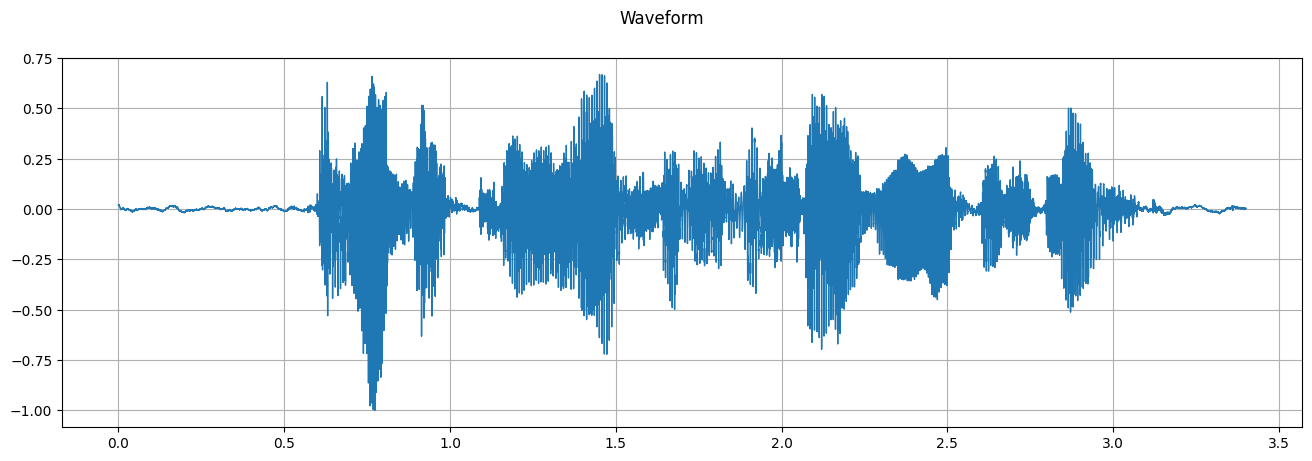

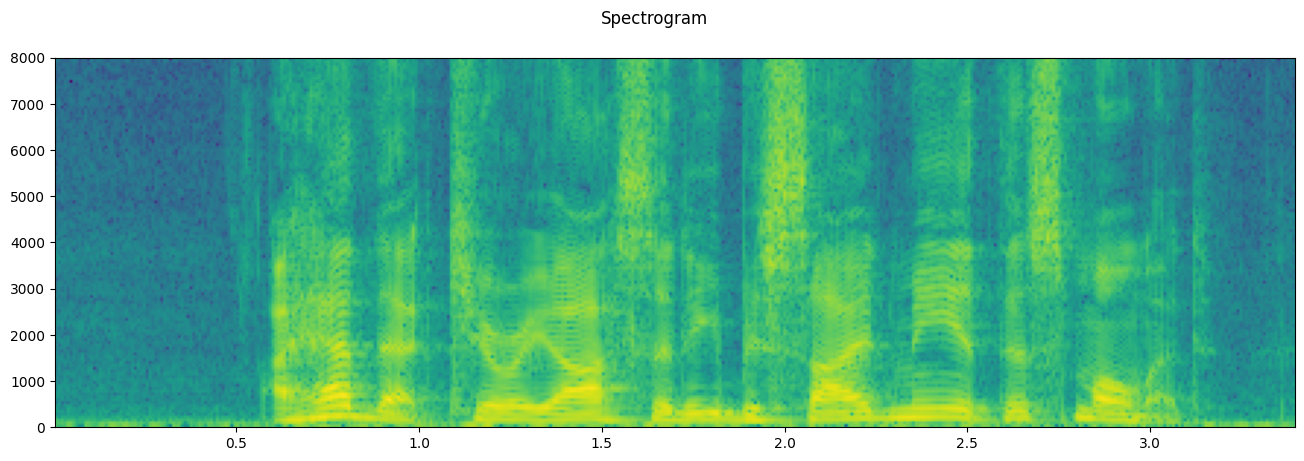

In [9]:
waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)

print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

In [10]:
# Load audio data as HTTP request
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform, sample_rate = torchaudio.load(response.raw)
plot_specgram(waveform, sample_rate, title="HTTP datasource")

# Load audio from tar file
with tarfile.open(SAMPLE_TAR_PATH, mode='r') as tarfile_:
  fileobj = tarfile_.extractfile(SAMPLE_TAR_ITEM)
  waveform, sample_rate = torchaudio.load(fileobj)
plot_specgram(waveform, sample_rate, title="TAR file")

# Load audio from S3
client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
response = client.get_object(Bucket=S3_BUCKET, Key=S3_KEY)
waveform, sample_rate = torchaudio.load(response['Body'])
plot_specgram(waveform, sample_rate, title="From S3")

Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_get_filelen at 0x000001DEF386CA60>:
Traceback (most recent call last):
  File "C:\Users\AI-STEELBEAR\anaconda3\envs\heart-beat\lib\site-packages\soundfile.py", line 1231, in vio_get_filelen
    file.seek(0, SEEK_END)
io.UnsupportedOperation: seek


LibsndfileError: Error opening <urllib3.response.HTTPResponse object at 0x000001DEF8902B30>: Error in WAV file. No 'data' chunk marker.

In [11]:
# Illustration of two different decoding methods.
# The first one will fetch all the data and decode them, while
# the second one will stop fetching data once it completes decoding.
# The resulting waveforms are identical.

frame_offset, num_frames = 16000, 16000  # Fetch and decode the 1 - 2 seconds

print("Fetching all the data...")
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform1, sample_rate1 = torchaudio.load(response.raw)
  waveform1 = waveform1[:, frame_offset:frame_offset+num_frames]
  print(f" - Fetched {response.raw.tell()} bytes")

print("Fetching until the requested frames are available...")
with requests.get(SAMPLE_WAV_SPEECH_URL, stream=True) as response:
  waveform2, sample_rate2 = torchaudio.load(
      response.raw, frame_offset=frame_offset, num_frames=num_frames)
  print(f" - Fetched {response.raw.tell()} bytes")

print("Checking the resulting waveform ... ", end="")
assert (waveform1 == waveform2).all()
print("matched!")

Fetching all the data...


Exception ignored from cffi callback <function SoundFile._init_virtual_io.<locals>.vio_get_filelen at 0x000001DEB89B3400>:
Traceback (most recent call last):
  File "C:\Users\AI-STEELBEAR\anaconda3\envs\heart-beat\lib\site-packages\soundfile.py", line 1231, in vio_get_filelen
    file.seek(0, SEEK_END)
io.UnsupportedOperation: seek


LibsndfileError: Error opening <urllib3.response.HTTPResponse object at 0x000001DEF894E080>: Error in WAV file. No 'data' chunk marker.

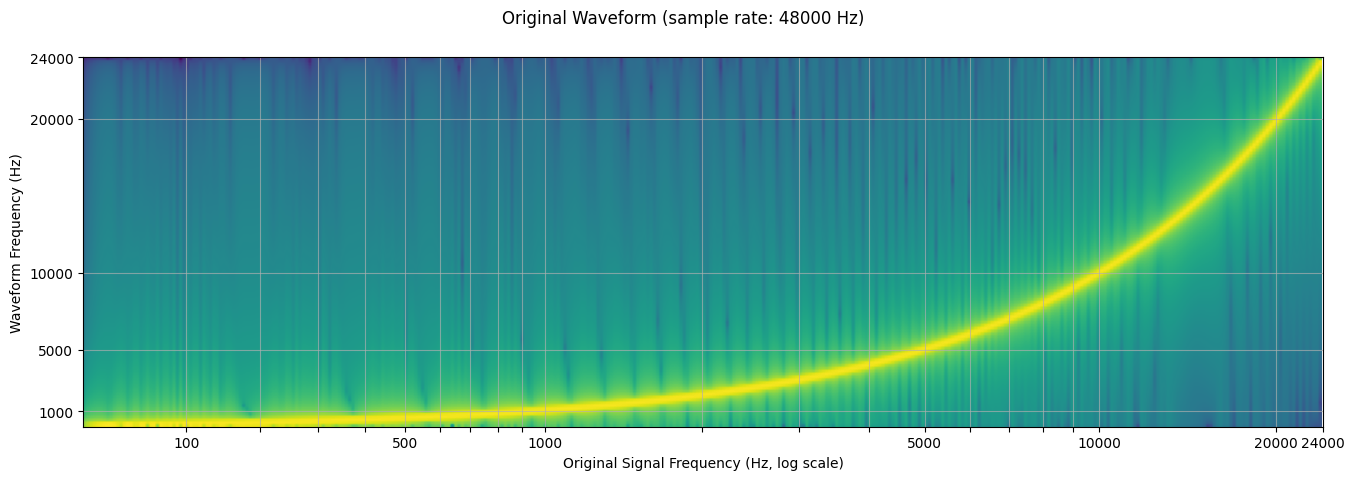

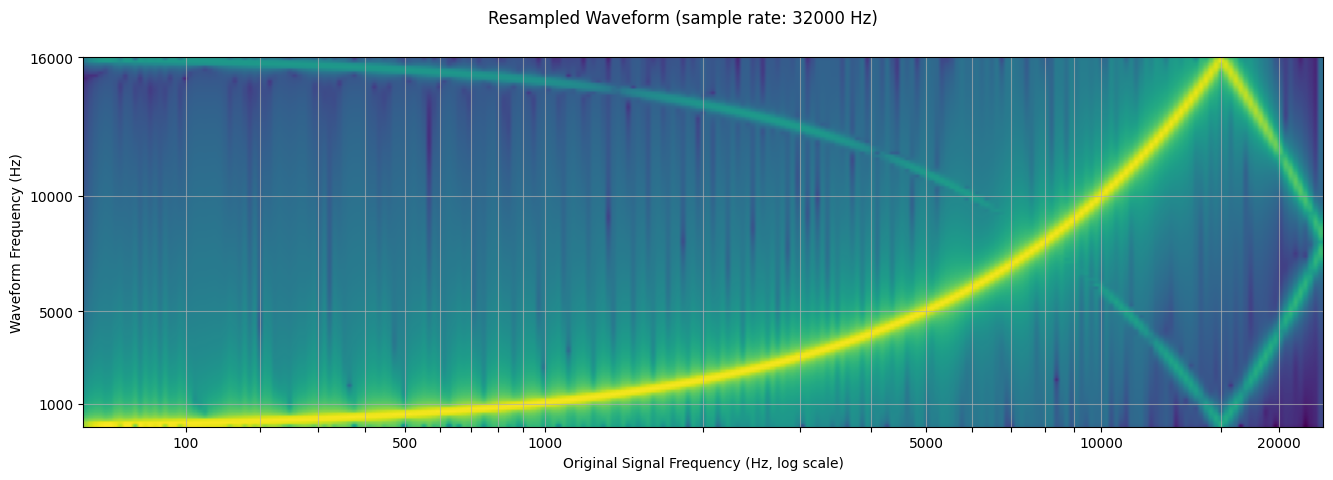

In [12]:
sample_rate = 48000
resample_rate = 32000

waveform = get_sine_sweep(sample_rate)
plot_sweep(waveform, sample_rate, title="Original Waveform")
play_audio(waveform, sample_rate)

resampler = T.Resample(sample_rate, resample_rate, dtype=waveform.dtype)
resampled_waveform = resampler(waveform)
plot_sweep(resampled_waveform, resample_rate, title="Resampled Waveform")
play_audio(waveform, sample_rate)

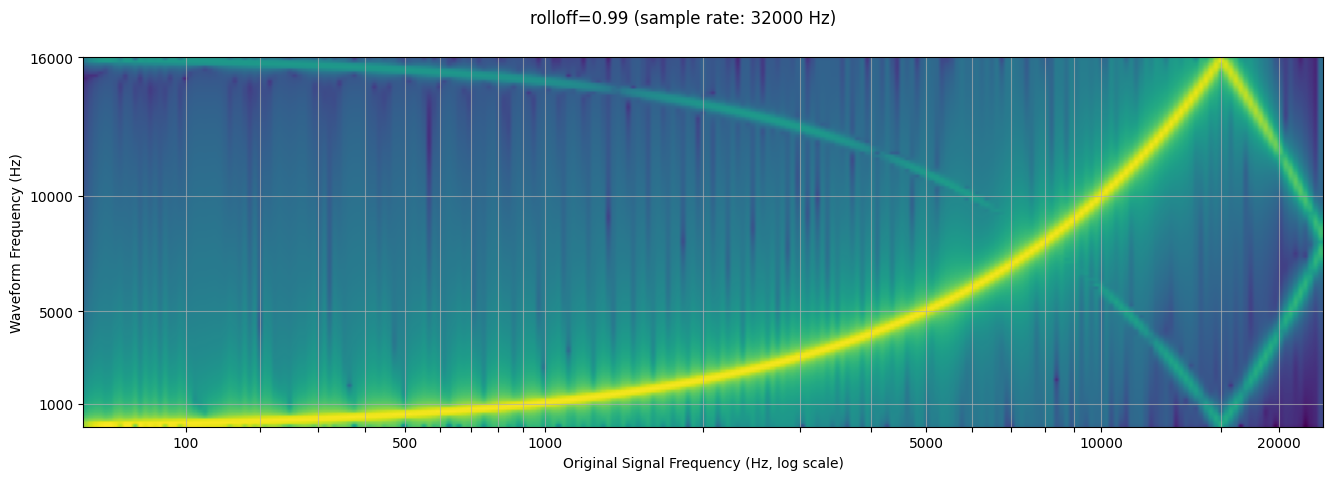

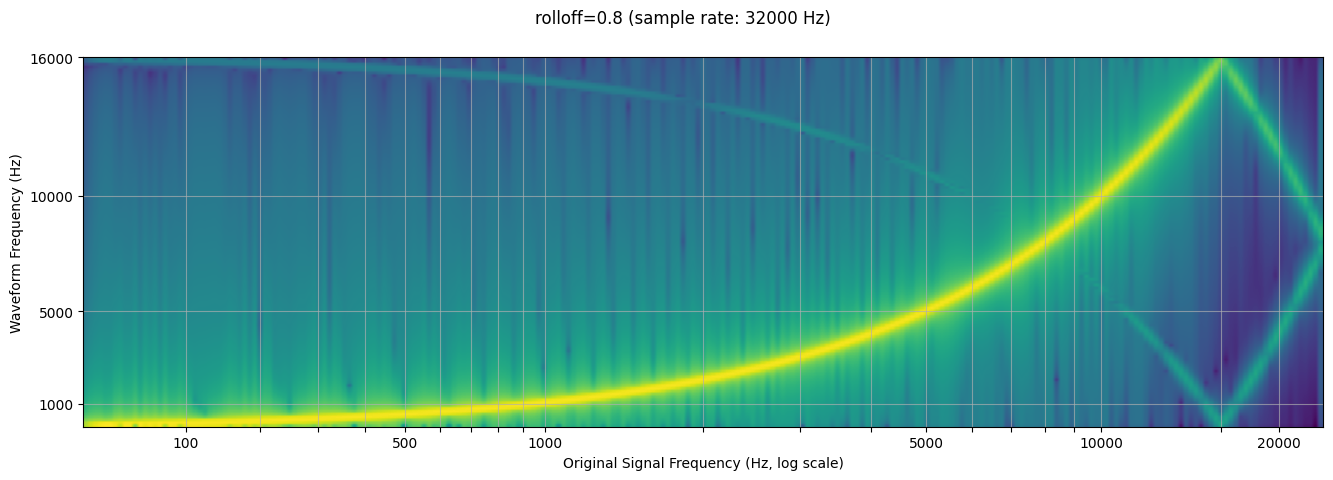

In [13]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.99)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.99")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, rolloff=0.8)
plot_sweep(resampled_waveform, resample_rate, title="rolloff=0.8")

C:\Users\AI-STEELBEAR\anaconda3\envs\heart-beat\lib\site-packages\torchaudio\functional\functional.py:1458: UserWarning: "sinc_interpolation" resampling method name is being deprecated and replaced by "sinc_interp_hann" in the next release. The default behavior remains unchanged.
  warnings.warn(


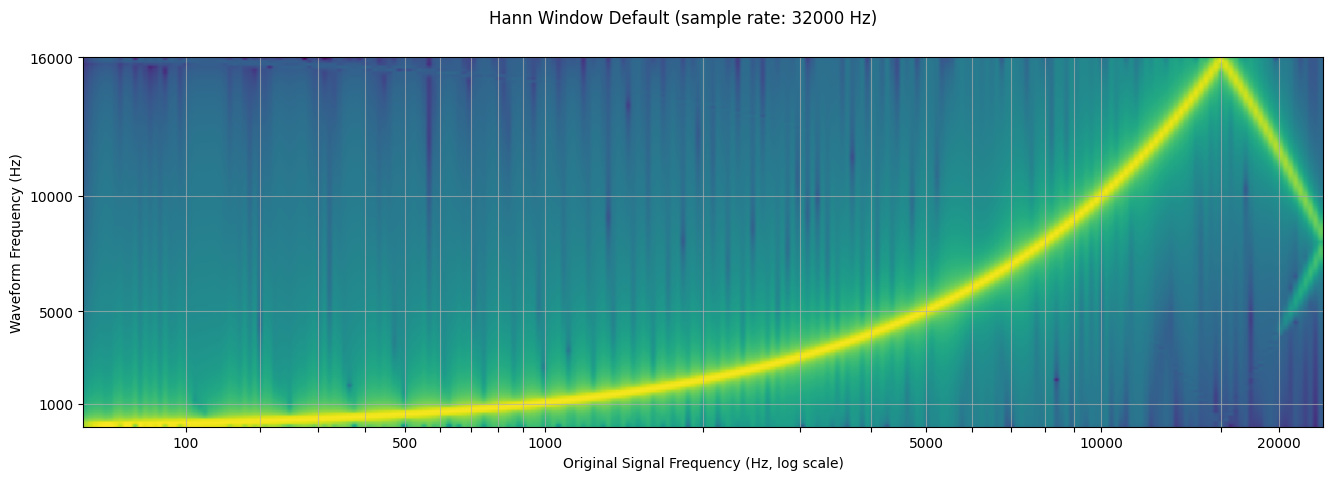

C:\Users\AI-STEELBEAR\anaconda3\envs\heart-beat\lib\site-packages\torchaudio\functional\functional.py:1458: UserWarning: "kaiser_window" resampling method name is being deprecated and replaced by "sinc_interp_kaiser" in the next release. The default behavior remains unchanged.
  warnings.warn(


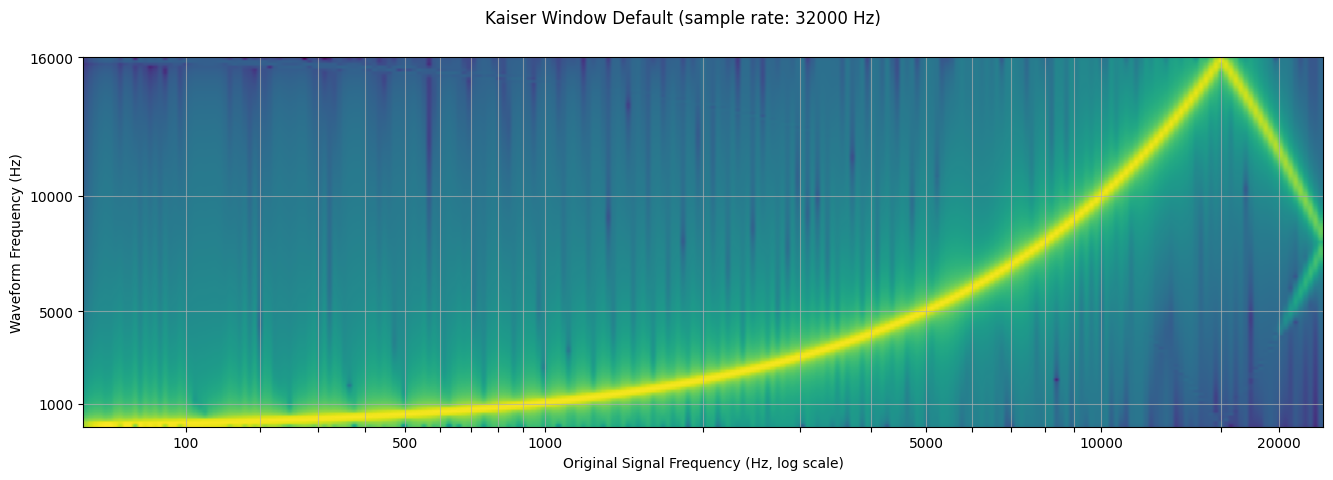

In [14]:
sample_rate = 48000
resample_rate = 32000

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="sinc_interpolation")
plot_sweep(resampled_waveform, resample_rate, title="Hann Window Default")

resampled_waveform = F.resample(waveform, sample_rate, resample_rate, resampling_method="kaiser_window")
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Default")

C:\Users\AI-STEELBEAR\anaconda3\envs\heart-beat\lib\site-packages\torchaudio\functional\functional.py:1458: UserWarning: "kaiser_window" resampling method name is being deprecated and replaced by "sinc_interp_kaiser" in the next release. The default behavior remains unchanged.
  warnings.warn(


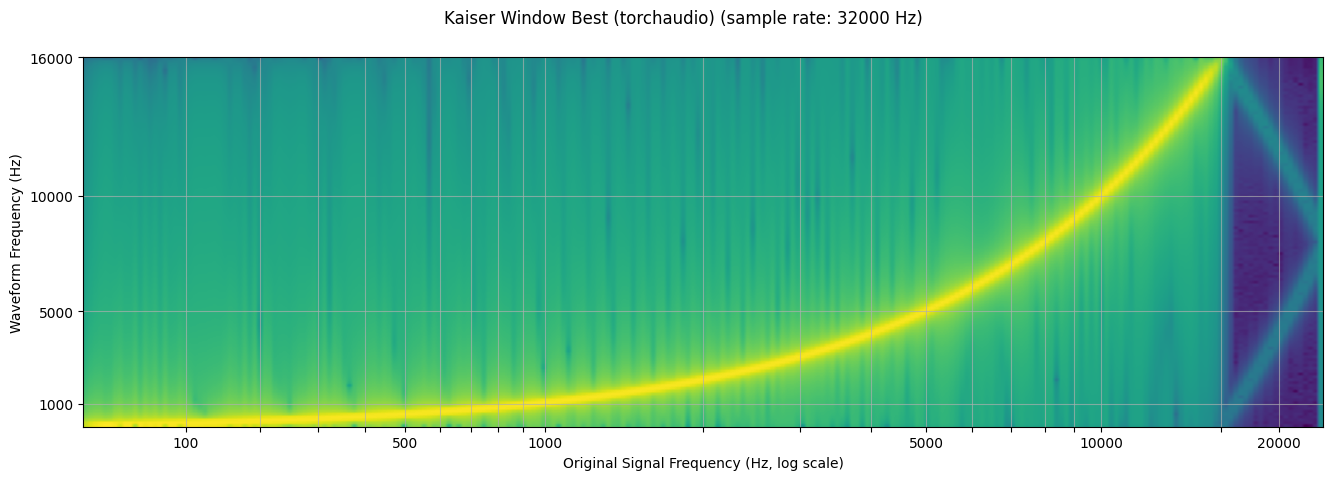

TypeError: resample() takes 1 positional argument but 3 positional arguments (and 1 keyword-only argument) were given

In [15]:
sample_rate = 48000
resample_rate = 32000

### kaiser_best
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="kaiser_window",
    beta=14.769656459379492
)
plot_sweep(resampled_waveform, resample_rate, title="Kaiser Window Best (torchaudio)")

librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), sample_rate, resample_rate, res_type='kaiser_best')).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Best (librosa)")

mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser best MSE:", mse)

### kaiser_fast
resampled_waveform = F.resample(
    waveform,
    sample_rate,
    resample_rate,
    lowpass_filter_width=16,
    rolloff=0.85,
    resampling_method="kaiser_window",
    beta=8.555504641634386
)
plot_specgram(resampled_waveform, resample_rate, title="Kaiser Window Fast (torchaudio)")

librosa_resampled_waveform = torch.from_numpy(
    librosa.resample(waveform.squeeze().numpy(), sample_rate, resample_rate, res_type='kaiser_fast')).unsqueeze(0)
plot_sweep(librosa_resampled_waveform, resample_rate, title="Kaiser Window Fast (librosa)")

mse = torch.square(resampled_waveform - librosa_resampled_waveform).mean().item()
print("torchaudio and librosa kaiser fast MSE:", mse)